## Training multi-fidelity neural networks for steady shear flows
The output of this notebook is the model's stored training, which is used to predict flow and temperature sweep responses.

### Importing the dependencies

In [335]:
from time import time
from datetime import datetime
import os
import sys
import math
import numpy as np
from numpy import random
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as mticker
from IPython.display import display, HTML
from matplotlib.pyplot import figure
import matplotlib.font_manager
from matplotlib import rc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

### Loading the Lo-Fi and Hi-Fi data
Similar to Lo-Fi data generation, it is possible to sample the Hi-Fi data and/or exclude flow curves as needed. See the below architecture.
In this example, the number of Lo-Fi NN inputs is 2: shear rate and temperature, so `n=2` in the blow image. Also, we have a 1-D output, which is viscosity. As an example, the $30^\circ\text{C}$ flow curve is masked here, as was masked in Lo-Fi data generation.

<img src="../Arch.jpg" alt="MFNN architecture" width="600"/>

In [336]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# 定义 log10 函数
def log10(x):
    return torch.log(x) / torch.log(torch.tensor(10.0, dtype=DTYPE))

# 数据路径
path = os.getcwd()
files = os.listdir(path)
df = {}
Shuffle = False

url_lf = 'Data_LF_FS.xlsx'
url_hf = 'Data_HF_FS.xlsx'

# 读取 Excel 文件
df_LF = pd.read_excel(url_lf, sheet_name=None)
data_LF = [[k, v] for k, v in df_LF.items()]  # k 是 sheet 名称，v 是 pandas DataFrame

df_HF = pd.read_excel(url_hf, sheet_name=None)
data_HF = [[k, v] for k, v in df_HF.items()]  # k 是 sheet 名称，v 是 pandas DataFrame

sample = 0

# 排除特定温度数据
data_test = data_HF[sample][1]
data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].Temperature != 30]

# 低频数据
x1_d_LF = torch.tensor(data_LF[sample][1]['ShearRate'].values, dtype=DTYPE).view(-1, 1)
x2_d_LF = torch.tensor(data_LF[sample][1]['Temperature'].values, dtype=DTYPE).view(-1, 1)
y1_d_LF = torch.tensor(data_LF[sample][1]['Viscosity'].values, dtype=DTYPE).view(-1, 1)

# 高频数据
x1_d_HF = torch.tensor(data_HF[sample][1]['ShearRate'].values, dtype=DTYPE).view(-1, 1)
x2_d_HF = torch.tensor(data_HF[sample][1]['Temperature'].values, dtype=DTYPE).view(-1, 1)
y1_d_HF = torch.tensor(data_HF[sample][1]['Viscosity'].values, dtype=DTYPE).view(-1, 1)
y1_d_HF_std = torch.tensor(data_HF[sample][1]['ViscositySTD'].values, dtype=DTYPE).view(-1, 1)

# 对 ShearRate 和 Viscosity 取对数
x1_d_HF = log10(x1_d_HF)
x1_d_LF = log10(x1_d_LF)

y1_d_HF = log10(y1_d_HF)
y1_d_LF = log10(y1_d_LF)

# 计算边界
x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
lb = torch.tensor([x1min, x2min], dtype=DTYPE).numpy()
ub = torch.tensor([x1max, x2max], dtype=DTYPE).numpy()

# 合并数据
X_data_HF = torch.cat([x1_d_HF, x2_d_HF], dim=1)
y_data_HF = y1_d_HF

X_data_LF = torch.cat([x1_d_LF, x2_d_LF], dim=1)
y_data_LF = y1_d_LF
# 1. 加入随机噪声
noise_X = torch.randn_like(X_data_LF)*0.8  # 噪声的标准差为0.1，可以根据需要调整
noise_y = torch.randn_like(y_data_LF)*0.8# 噪声的标准差为0.1，可以根据需要调整

X_data_LF_noisy = X_data_LF + noise_X
y_data_LF_noisy = y_data_LF + noise_y

# 2. 数据量扩大十倍
X_data_LF = torch.cat([X_data_LF_noisy], dim=0)
y_data_LF = torch.cat([y_data_LF_noisy], dim=0)

Xy_data_HF = torch.cat([x1_d_HF, x2_d_HF, y1_d_HF], dim=1)
Xy_data_LF = torch.cat([x1_d_LF, x2_d_LF, y1_d_LF], dim=1)

# 如果需要打乱数据
if Shuffle:
    Xy_data_HF = Xy_data_HF[torch.randperm(Xy_data_HF.size(0))]
    Xy_data_LF = Xy_data_LF[torch.randperm(Xy_data_LF.size(0))]
    X_data_HF = Xy_data_HF[:, 0:2]
    y_data_HF = Xy_data_HF[:, 2:3]
    X_data_LF = Xy_data_LF[:, 0:2]
    y_data_LF = Xy_data_LF[:, 2:3]

# 输入和输出的维度
in_dim, out_dim = 2, 1

### Defining the NN
Here, `PINN_NeuralNet` is a `tf.keras.Model` instance with several fully-connected layers.

In [337]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

### Modifying the NN training procedure
The functions `update_last_n_losses()` and `ES()` are defined to provide early stopping of training once the relative error in the last 20 iterations is not changing below a threshold, i.e., $2\times10^{-3}$.

The function `loss_fn()` provides the MFNN architecture and error heuristics; see the above image and follow along the `loss_fn()` lines. L2 norms are necessary to control overfitting and regularize the model.

Finally, a `for` loop with call the `train_step()` function for a set number of iterations (`N`). Note that the `max_relative_error` variable will terminate the training loop once the early stopping procedure is triggered.

The `callback()` is responsible for printing the loss values, while `plot_loss_history()` provides the loss history w.r.t. iterations.

In [338]:
class PINNSolver():
    def __init__(self, model_LF, model_HF_nl, model_HF_l):
        self.model_LF = model_LF  # 低保真模型
        self.model_HF_nl = model_HF_nl  # 高保真非线性模型
        self.model_HF_l = model_HF_l  # 高保真线性模型
        self.hist = []  # 损失历史列表
        self.iter = 0  # 迭代次数
        self.last_n_losses = []  # 前 n 次损失列表
        # 定义可学习的权重 alpha，初始化为 [1.0]
        self.alpha = nn.Parameter(torch.tensor([1.0], requires_grad=True))
        # 初始化 alpha_history 并记录初始值 1.0（以独立的 numpy 数组形式）
        self.alpha_history = [np.array([1.0], dtype=np.float32)]  # 添加初始值 1.0

    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        # 记录当前 alpha 值（使用独立的 numpy 数组）
        self.alpha_history.append(np.array([self.alpha.item()], dtype=np.float32))  # 使用 .item() 转换为标量并存储
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # 如果不足 20 次，返回一个大数
        current_loss = self.last_n_losses[-1]
        max_relative_error = 100. * max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error

    def loss_fn(self, X_data_LF, X_data_HF, y_data_LF, y_data_HF):
        y_pred_LF = self.model_LF(X_data_LF)
        y_pred_LF_HF = self.model_LF(X_data_HF)
        y_pred_HF_nl = self.model_HF_nl(torch.cat([X_data_HF, y_pred_LF_HF], dim=1))
        y_pred_HF_l = self.model_HF_l(torch.cat([X_data_HF, y_pred_LF_HF], dim=1))
        y_pred_HF = y_pred_HF_nl + y_pred_HF_l

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_HF_nl.parameters())
        Loss_L2 += 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_LF.parameters())
        Loss_data_LF = torch.mean((y_data_LF - y_pred_LF)**2)
        Loss_data_HF = torch.mean((y_data_HF - y_pred_HF)**2)

        # 使用可学习的权重 alpha
        loss = self.alpha[0] * Loss_data_LF + Loss_data_HF + Loss_L2
        loss_frac = [Loss_data_LF.item(), Loss_data_HF.item(), Loss_L2]
        return loss, loss_frac

    def solve_with_PyTorch_optimizer(self, optimizer, X_data_LF, X_data_HF, y_data_LF, y_data_HF, scheduler, N=1001):
        for i in range(N):
            optimizer.zero_grad()
            loss, loss_frac = self.loss_fn(X_data_LF, X_data_HF, y_data_LF, y_data_HF)
            loss.backward()
            scheduler.step(loss)
            optimizer.step()
         # 动态缩放 alpha 的梯度
            with torch.no_grad():
                min_alpha = 0.734  # alpha 的最小值
                distance = self.alpha.data - min_alpha  # alpha 与最小值的距离
                scale_factor = torch.clamp(distance, min=1e-3)  # 防止梯度消失
                self.alpha.grad *= scale_factor  # 缩放梯度
            # 手动裁剪 alpha 的范围
            with torch.no_grad():
                self.alpha.data = torch.clamp(self.alpha.data, min=min_alpha)  # 确保 alpha >= 0.33
            self.loss_frac = loss_frac
            self.current_loss = loss.item()
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error, N)
            self.update_last_n_losses(self.current_loss)

            if self.max_relative_error < 2e-3:  # 早停条件
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter, self.current_loss, np.round(self.max_relative_error, 3)))
                #break

    def callback(self, xr=None, N=1001):
        if self.iter % 100 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %, Alpha = {}'.format(
                self.iter, self.current_loss, np.round(self.max_relative_error, 2), self.alpha.detach().numpy()))
        self.hist.append(self.current_loss)
        self.iter += 1

    def plot_loss_history(self, ax=None):
        if not ax:
            fig, ax = plt.subplots(figsize=(7, 5))
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        return ax

    def plot_alpha_history(self):
        alpha_history = np.array(self.alpha_history)
        plt.figure(figsize=(7, 5),dpi=300)
        
        # 使用 plot 绘制曲线图，不显示数据点
        plt.plot(range(len(alpha_history[:, 0])), alpha_history[:, 0], color='blue', linestyle='-', linewidth=3, label='$\\alpha$')
        
        # 设置横纵坐标的字体大小
        plt.xlabel('Epoch', fontsize=18)
        plt.ylabel('Weight ($\\alpha_{LF}$)', fontsize=18)
        
        # 设置横纵坐标刻度的字体大小
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        # 显示图像
        plt.show()

### Instantiating the NNs and the solver
Here, the Lo-Fi, the nonlinear Hi-Fi, and the linear Hi-Fi NNs are instantiated from the `PINN_NeuralNet()` class. There are then built with their specified input shapes. We had `n=2`, which is `in_dim` in the below cell. We also have a 1-D output, which is viscosity. Therefore, the Lo-Fi NN takes `in_dim=2`-D inputs and spits `out_dim=1`-D output. Then, the nonlinear Hi-Fi NN lifts the `out_dim=1`-D Lo-Fi output + its own inputs, which are `in_dim=2`-D; same thing for the nonlinear Hi-Fi data. That's why the Hi-Fi NNs accept `in_dim+out_dim`-D inputs; see the above image for reference.

In [339]:
# 定义模型
model_LF = PINN_NeuralNet(input_dim=in_dim,
                          output_dim=out_dim,
                          num_hidden_layers=4,
                          num_neurons_per_layer=64,
                          activation='tanh'
                          )
model_HF_nl = PINN_NeuralNet(input_dim=in_dim+out_dim,
                             output_dim=out_dim,
                             num_hidden_layers=3,
                             num_neurons_per_layer=64,
                             activation='tanh')
model_HF_l = PINN_NeuralNet(input_dim=in_dim+out_dim,
                            output_dim=out_dim,
                            num_hidden_layers=1,
                            num_neurons_per_layer=10,
                            activation='linear')

# 初始化 PINNSolver
solver = PINNSolver(model_LF, model_HF_nl, model_HF_l)


### MFNN training
We almost have everything by now. Next, we will instantiate the optimizer from `tf.keras.optimizers.legacy.Adam` with a specified learning rate. A piecewise learning rate is also provided. Then, the optimizer is called on `solver` with appropriate datasets.

In [340]:
# 定义学习率调度器
lr = 1e-3
# 定义优化器，将 alpha 添加到优化参数中
optimizer = torch.optim.Adam([
    {'params': solver.model_LF.parameters()},
    {'params': solver.model_HF_nl.parameters()},
    {'params': solver.model_HF_l.parameters()},
    {'params': solver.alpha}
])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(5000) + 1  # 训练迭代次数
batch_size=1000
try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        # 创建数据加载器
        dataset_LF = TensorDataset(X_data_LF, y_data_LF)
        dataset_HF = TensorDataset(X_data_HF, y_data_HF)
        dataloader_LF = DataLoader(dataset_LF, batch_size=batch_size, shuffle=True)
        dataloader_HF = DataLoader(dataset_HF, batch_size=batch_size, shuffle=True)
        t0 = time()
        for (X_batch_LF, y_batch_LF), (X_batch_HF, y_batch_HF) in zip(dataloader_LF, dataloader_HF):
         solver.solve_with_PyTorch_optimizer(optimizer, X_data_LF, X_data_HF, y_data_LF, y_data_HF,scheduler,N=N)
         runtime += (time() - t0) / 60.
         print('\nRuntime: {:.3f} minutes'.format(runtime))
         break
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

/home/redfu/anaconda3/envs/PINN/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


It 0,000: Loss = 4.6487e+02, Max. rel. error = 100 %, Alpha = [0.999]
It 0,100: Loss = 7.6508e-01, Max. rel. error = 11.71 %, Alpha = [0.9572262]
It 0,200: Loss = 7.0198e-01, Max. rel. error = 33.47 %, Alpha = [0.94794285]
It 0,300: Loss = 6.7116e-01, Max. rel. error = 0.18 %, Alpha = [0.9444206]
It 0,400: Loss = 6.6579e-01, Max. rel. error = 0.14 %, Alpha = [0.94079876]
It 0,500: Loss = 6.6093e-01, Max. rel. error = 0.14 %, Alpha = [0.9366067]
It 0,600: Loss = 6.5623e-01, Max. rel. error = 0.14 %, Alpha = [0.93187344]
It 0,700: Loss = 6.5148e-01, Max. rel. error = 0.14 %, Alpha = [0.9266158]
It 0,800: Loss = 6.4660e-01, Max. rel. error = 0.15 %, Alpha = [0.92084354]
It 0,900: Loss = 6.4153e-01, Max. rel. error = 0.15 %, Alpha = [0.914562]
It 1,000: Loss = 6.3623e-01, Max. rel. error = 0.16 %, Alpha = [0.9077729]
It 1,100: Loss = 6.3067e-01, Max. rel. error = 0.17 %, Alpha = [0.9004761]
It 1,200: Loss = 6.2484e-01, Max. rel. error = 0.18 %, Alpha = [0.8926696]
It 1,300: Loss = 6.1872e-

### Visualizing the results

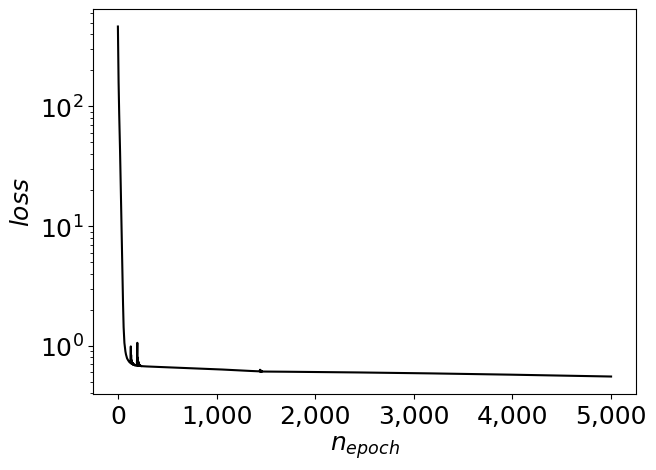

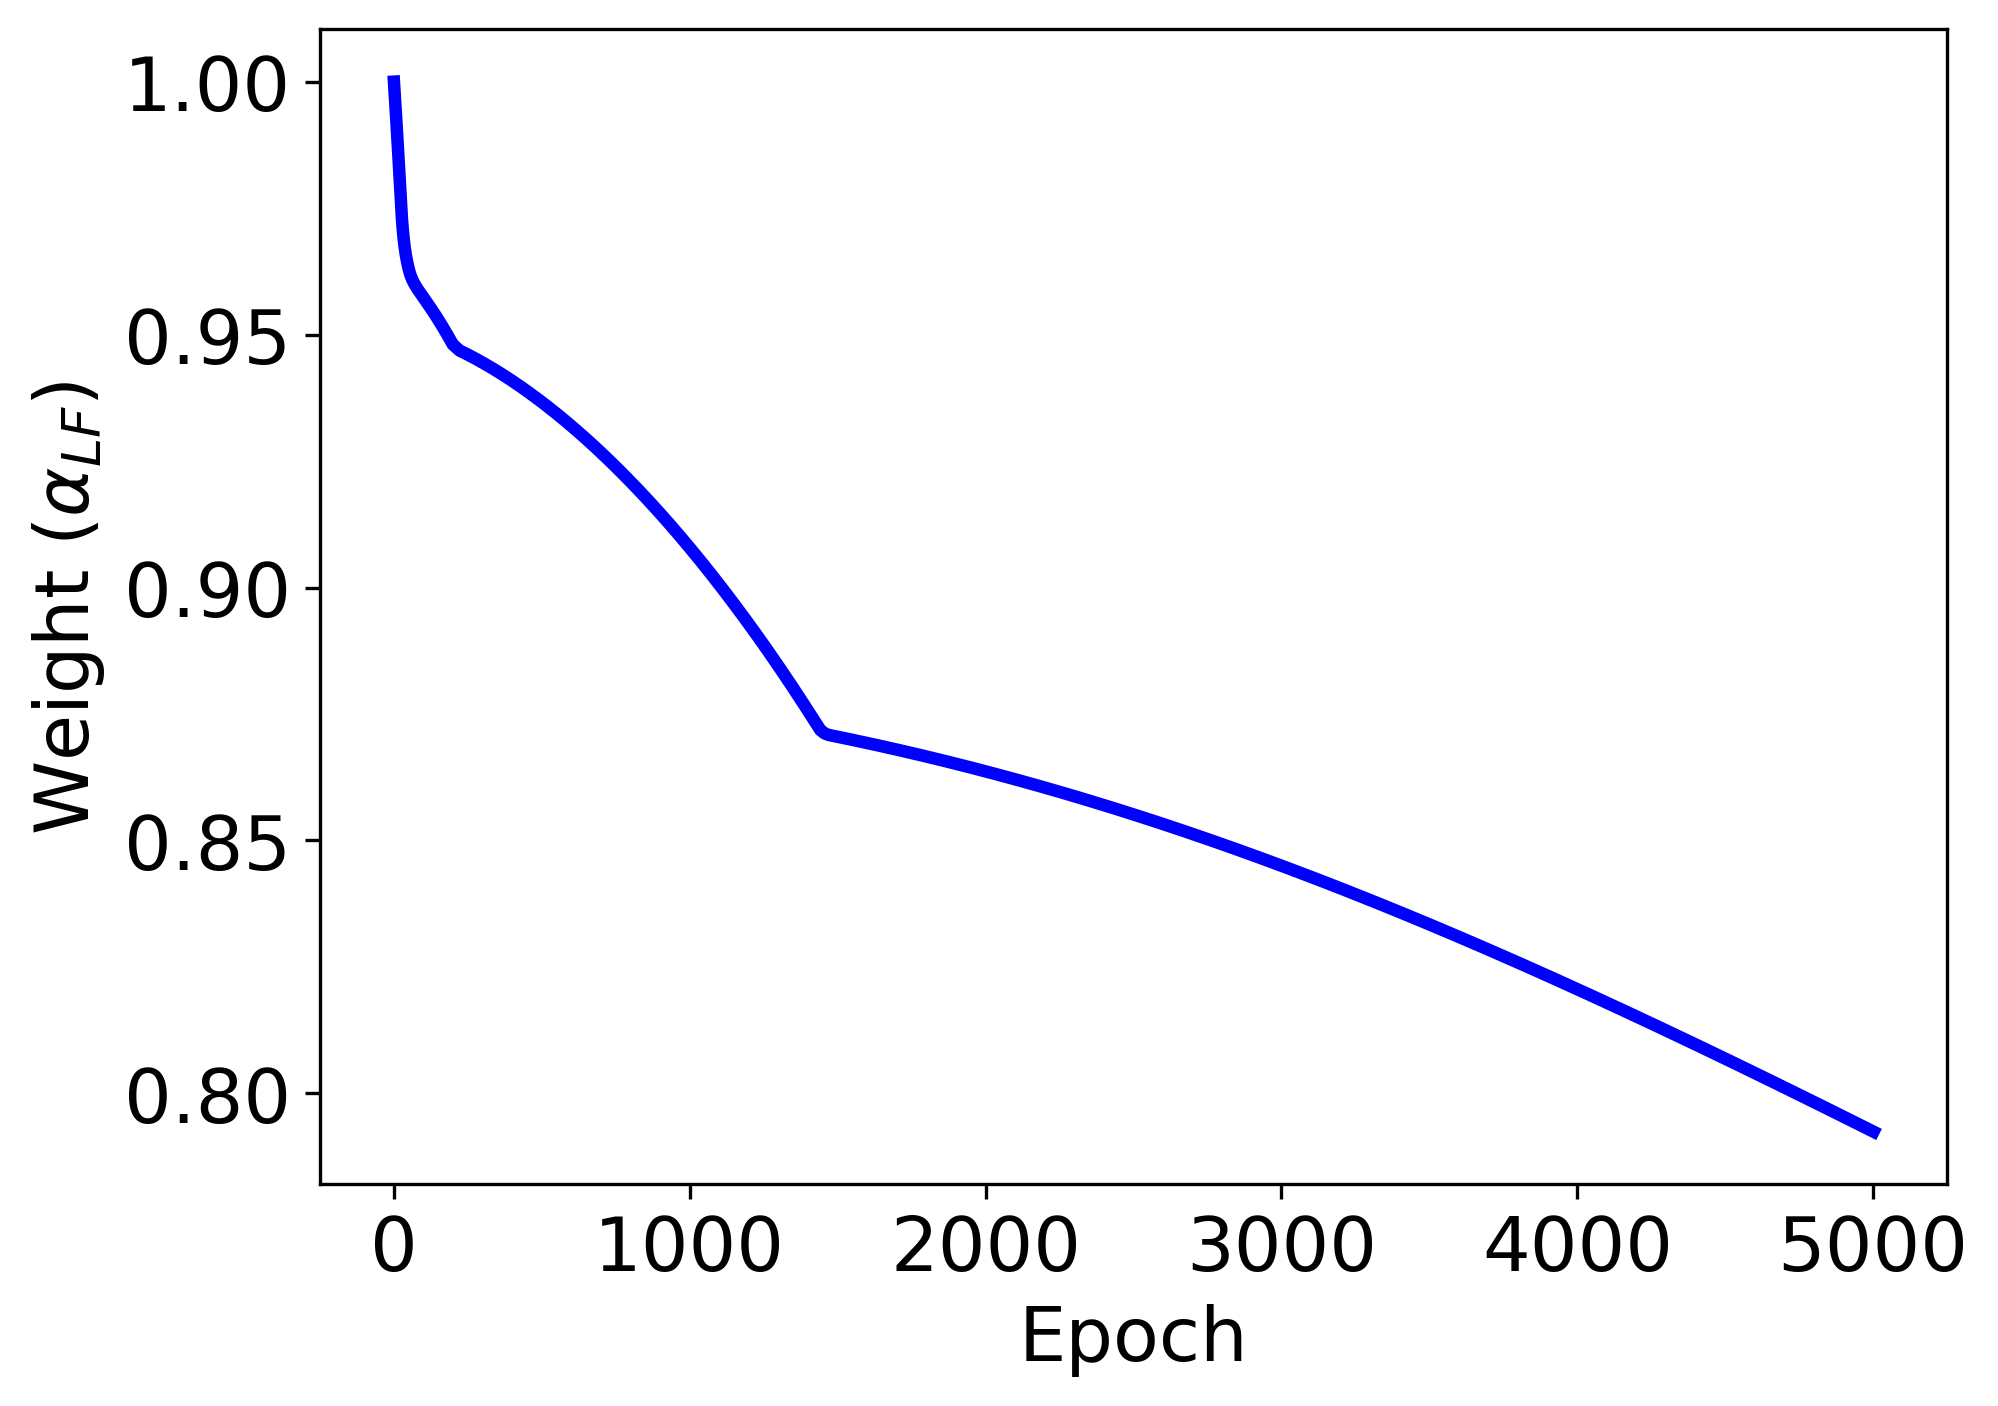

In [341]:
solver.plot_loss_history()
solver.plot_alpha_history()

### Plotting the flow sweeps
Here, MFNN is called for all temperatures in `data_test`, which is the Hi-Fi data before the exclusion step. Hollow symbols are entirely masked during the Lo-Fi data generation and MFNN training. The same notation is used for other flow protocols.

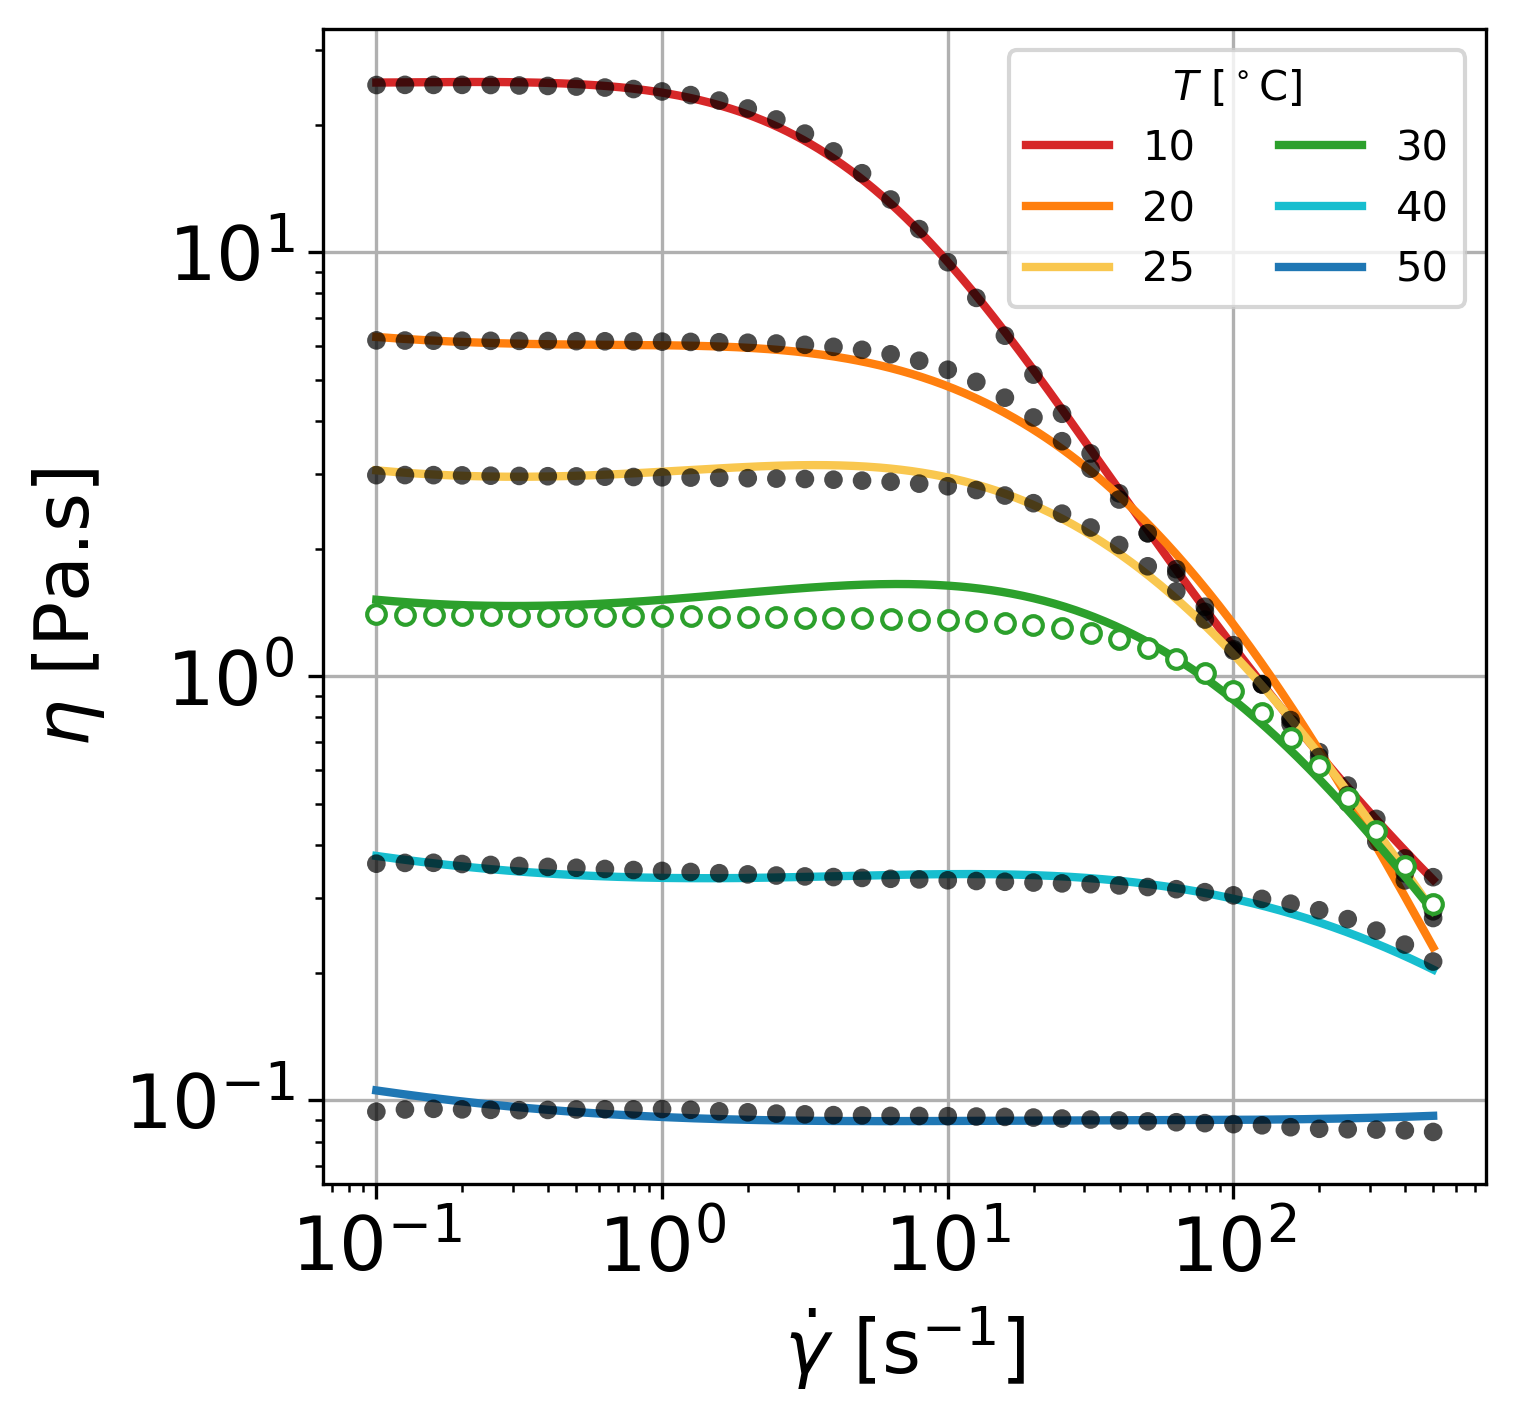

In [342]:
# 设置 Matplotlib 的字体大小
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)

# 定义颜色
n_tests = 6
colors = plt.cm.jet(np.linspace(.2, 0.9, n_tests))
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue']

# 创建图形和轴
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

# 提取高频数据
SR_HF, T_HF, eta_HF = Xy_data_HF[:, 0], Xy_data_HF[:, 1], Xy_data_HF[:, 2]

# 定义绘图点数
N_exp = 400
SR_plot = np.linspace(np.min(SR_HF.numpy()), np.max(SR_HF.numpy()), N_exp).reshape(-1, 1)
Temp = np.unique(data_test.Temperature)
i = 0
SR_pred = []
T_pred = []
eta_pred = []

# 遍历每个温度
for items in Temp:
    T_plot = items * np.ones(N_exp).reshape(-1, 1)
    X_LF = torch.cat([torch.tensor(SR_plot, dtype=DTYPE), torch.tensor(T_plot, dtype=DTYPE)], dim=1)
    y_LF = model_LF(X_LF)  # 假设 model_LF 是一个 PyTorch 模型
    X_MF = torch.cat((X_LF, y_LF), dim=1)
    y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)  # 假设 model_HF_nl 和 model_HF_l 是 PyTorch 模型
    ax.plot(10 ** SR_plot, 10 ** y_MF.detach().numpy(), label=int(items), lw=2., color=colors[i], alpha=1.)

    x1_test = data_test[data_test.Temperature == items]['ShearRate']
    x2_test = data_test[data_test.Temperature == items]['Temperature']
    y1_test = data_test[data_test.Temperature == items]['Viscosity']

    if items in np.unique(x2_d_HF.numpy()):
        ax.scatter(x1_test, y1_test,
                   s=20, color='k', zorder=2, alpha=0.7, edgecolors='none')

        i += 1
    else:
        ax.scatter(x1_test, y1_test, color=colors[i],
                   alpha=1., zorder=10, s=20, marker='o', lw=1., facecolors='white', edgecolors=colors[i])
        i += 1

    ax.set_xscale('log')
    ax.set_yscale('log')

    SR_pred = np.append(SR_pred, SR_plot)
    T_pred = np.append(T_pred, T_plot)
    eta_pred = np.append(eta_pred, y_MF.detach().numpy())

    legend = ax.legend(ncol=2, loc='best', title=r'$T$ [$\mathrm{^\circ C}$]', fontsize=10)
    plt.setp(legend.get_title(), fontsize=10)

ax.set_ylabel(r'$\eta$ [Pa.s]')
ax.set_xlabel(r'$\dot{\gamma}$ [$\mathrm{s^{-1}}$]')
ax.grid()

# plt.savefig("datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_FS.png", bbox_inches='tight', dpi=600)
plt.show()

### The temperature sweep flow curve at $\dot\gamma=60 s^{-1}$
The temperature sweep serves as the test case, and was unseen by the NN.

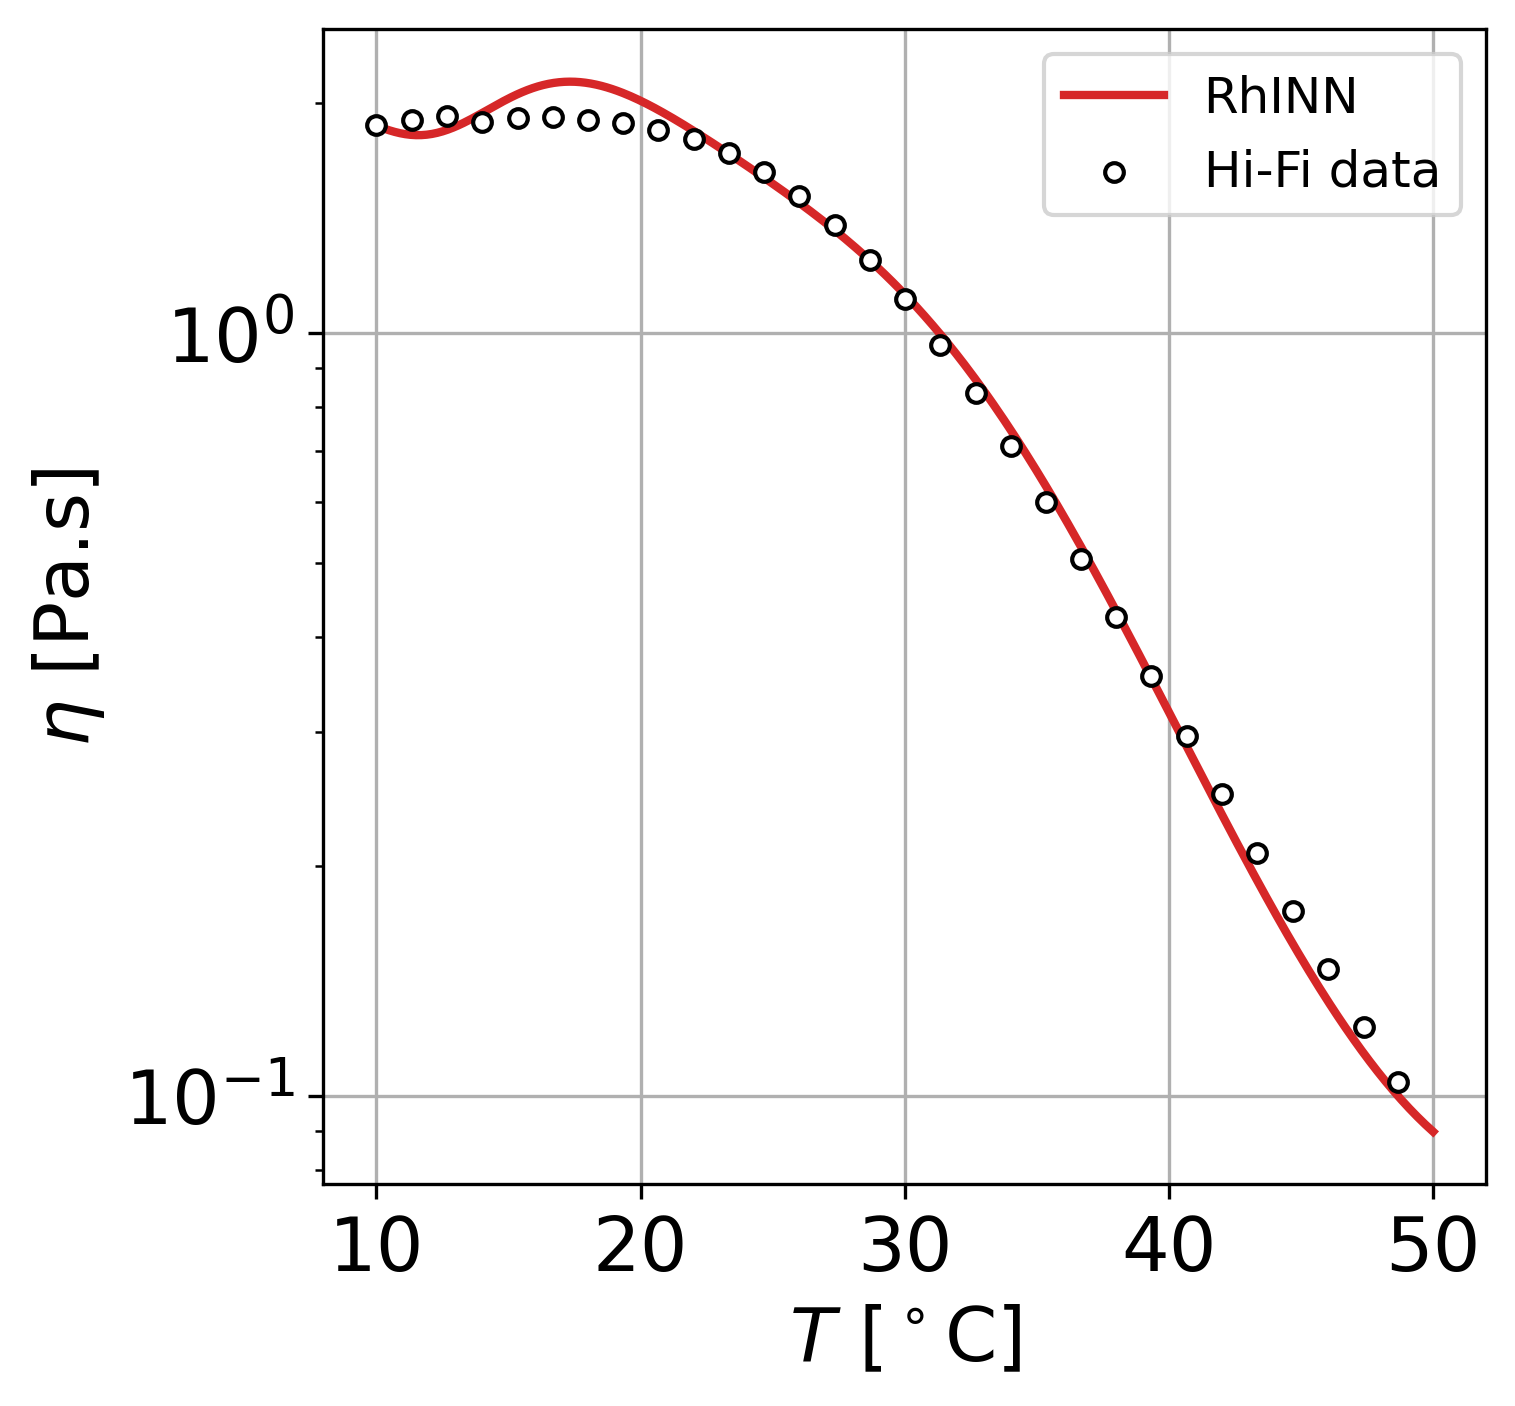

In [343]:
# 设置字体大小
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

# 读取测试数据
url_test = 'Data_HF_TS_test.xlsx'
df_test = pd.read_excel(url_test, sheet_name=None)
df_test = [[k, v] for k, v in df_test.items()]

# 假设 sample 是一个有效的索引
sample = 0

# 转换数据为 PyTorch 的 Tensor
x1_test = torch.tensor(df_test[sample][1]['ShearRate'].values, dtype=torch.float32).view(-1, 1)
x2_test = torch.tensor(df_test[sample][1]['Temperature'].values, dtype=torch.float32).view(-1, 1)
y1_test = torch.tensor(df_test[sample][1]['Viscosity'].values, dtype=torch.float32).view(-1, 1)
y1_test_std = torch.tensor(df_test[sample][1]['ViscositySTD'].values, dtype=torch.float32).view(-1, 1)

# 定义 N_exp
N_exp = 400

# 生成 SR_plot 和 T_plot
SR_test = np.log10(60.)
SR_plot = SR_test * np.ones(N_exp).reshape(-1, 1)
T_plot = np.linspace(10., 50., N_exp).reshape(-1, 1)

# 将 SR_plot 和 T_plot 转换为 PyTorch 的 Tensor
SR_plot = torch.tensor(SR_plot, dtype=torch.float32)
T_plot = torch.tensor(T_plot, dtype=torch.float32)

# 拼接 SR_plot 和 T_plot
X_LF = torch.cat([SR_plot, T_plot], dim=1)

# 假设 model_LF 是一个 PyTorch 模型
y_LF = model_LF(X_LF)

# 确保 y_LF 的形状是 (N_exp, 1)
y_LF = y_LF.view(-1, 1)

# 将 X_LF 和 y_LF 拼接成 X_MF
X_MF = torch.cat([X_LF, y_LF], dim=1)

# 假设 model_HF_nl 和 model_HF_l 是 PyTorch 模型
y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)

# 计算 y_MF 的 10 的幂
y_MF = 10 ** y_MF

# 绘制预测结果
ax.plot(T_plot.numpy(), y_MF.detach().numpy(), label='RhINN', color='tab:red', lw=2.)

# 绘制测试数据
ax.scatter(x2_test[::40].numpy(), y1_test[::40].numpy(),
           label='Hi-Fi data', s=20, color='k', zorder=2, alpha=1, edgecolors='k', facecolor='white')

# 设置图例
legend = ax.legend(loc='best', fontsize=12)
plt.setp(legend.get_title(), fontsize=12)

# 设置对数刻度
ax.set_yscale('log')

# 设置轴标签
ax.set_ylabel('$\eta$ [Pa.s]')
ax.set_xlabel('$T$ [$\mathrm{^\circ C}$]')

# 显示网格
ax.grid()

# 显示图形
plt.show()